In [25]:
import pandas as pd
import os
import numpy as np
import datetime
import chardet
import time
from matplotlib import pyplot as plt
from collections import Counter
from itertools import combinations

In [116]:
soot_results = pd.read_csv('soot-results.csv', sep=';', encoding='latin-1', on_bad_lines='skip', low_memory=False)
loi = pd.read_csv('LOI.csv', sep=';', encoding='latin-1', on_bad_lines='skip', low_memory=False)

In [29]:
def get_loi(project, class_name,  method, merge_commit):

        filter_scenario = (loi['Project'] == str(project)) & (loi['Merge Commit'] == str(merge_commit)) & (loi['Class Name'] == str(class_name)) & (loi['Method or field declaration changed by the two merged branches'] == str(method))
        value_LOI = ""

        if filter_scenario.any():
            value_LOI = loi.loc[filter_scenario, 'Locally Observable Interference'].values[0]

        return value_LOI

In [285]:
info_LOI = ['project', 'class', 'method', 'merge commit']

list_values = soot_results.columns.tolist()
remove_columns = ['project', 'class', 'method', 'merge commit', 'Time']
analysis = [coluna for coluna in list_values if coluna not in remove_columns]



In [286]:
left_right_analysis = list(set([x.replace("left right ", "") for x in analysis if "left right " in x]))
analysis_name = list(set([x.replace("left right ", "").replace("right left ", "") for x in analysis]))
print(analysis_name)


['PDG', 'CDe', 'CD', 'DFP-Inter', 'Confluence Inter', 'DFP-Intra', 'PDG-e', 'Confluence Intra', 'OA Inter']


In [77]:
def get_name_analysis(list_name):
    names = []
    for i in list_name:
        if (i in left_right_analysis):
            names.append("left right "+i)
            names.append("right left "+i)
        else:
            names.append(i)
    return names

def get_reverse_name(lists):
    names = []
    for elem_list in lists:
        aux_list = []
        for i in elem_list:
            if "left right" in i:
                aux_list.append(i.replace("left right ", ""))
            elif ("right left " not in i):
                aux_list.append(i)
        names.append(aux_list)
    return names


In [123]:
# Lista dos elementos
elements = analysis_name
combinations_list = []
# Gerar todas as combinações possíveis de 2 a 4 elementos sem repetições
for length in range(1, len(elements) + 1):
    for combination in combinations(elements, length):
        combinations_list.append(list(combination))

print(combinations_list)

# gerando todas as combinações possíveis

analysis_combination = []
for i in combinations_list:
    analysis_combination.append(get_name_analysis(i))
print(analysis_combination)

[['PDG'], ['CDe'], ['CD'], ['DFP-Inter'], ['Confluence Inter'], ['DFP-Intra'], ['PDG-e'], ['Confluence Intra'], ['OA Inter'], ['PDG', 'CDe'], ['PDG', 'CD'], ['PDG', 'DFP-Inter'], ['PDG', 'Confluence Inter'], ['PDG', 'DFP-Intra'], ['PDG', 'PDG-e'], ['PDG', 'Confluence Intra'], ['PDG', 'OA Inter'], ['CDe', 'CD'], ['CDe', 'DFP-Inter'], ['CDe', 'Confluence Inter'], ['CDe', 'DFP-Intra'], ['CDe', 'PDG-e'], ['CDe', 'Confluence Intra'], ['CDe', 'OA Inter'], ['CD', 'DFP-Inter'], ['CD', 'Confluence Inter'], ['CD', 'DFP-Intra'], ['CD', 'PDG-e'], ['CD', 'Confluence Intra'], ['CD', 'OA Inter'], ['DFP-Inter', 'Confluence Inter'], ['DFP-Inter', 'DFP-Intra'], ['DFP-Inter', 'PDG-e'], ['DFP-Inter', 'Confluence Intra'], ['DFP-Inter', 'OA Inter'], ['Confluence Inter', 'DFP-Intra'], ['Confluence Inter', 'PDG-e'], ['Confluence Inter', 'Confluence Intra'], ['Confluence Inter', 'OA Inter'], ['DFP-Intra', 'PDG-e'], ['DFP-Intra', 'Confluence Intra'], ['DFP-Intra', 'OA Inter'], ['PDG-e', 'Confluence Intra'], ['P

In [97]:
def calculate_matrix(columns):
    results = []
    for index, row in soot_results.iterrows():
        values = [row[column] for column in columns]
        actual_loi = get_loi(row['project'], row['class'], row['method'], row['merge commit'])
        or_value = any(value != 'false' for value in values)
        result = ""
        # print("OR:", or_value, "LOI:", actual_loi)
        if or_value == True and actual_loi == 'Yes':
            result = "TRUE POSITIVE"
        elif or_value == False and actual_loi == 'No':
            result = "TRUE NEGATIVE"
        elif or_value == False and actual_loi == 'Yes':
            result = "FALSE NEGATIVE"
        elif or_value == True and actual_loi == 'No':
            result = "FALSE POSITIVE"
        if actual_loi != "-":
            results.append(result)
    return results

In [68]:
#Algoritmo
#Se todos os TP e TN de uma análise A1 são também TP e TN de outra análise A2, e A2 tem pelo 
#menos um TP ou TN a mais que A1, o algoritmo indica que a gente deve ficar apenas com A2

#Se todos os TP e TN de uma análise A1 são também TP e TN de outra análise A2, e A2 não tem 
#nenhum TP ou TN a mais que A1, o algoritmo indica que a gente deve ficar com a mais rápida entre A1 e A2

#Se nem todos os TP e TN de uma análise A1 são também TP e TN de outra análise A2, e vice-versa, 
#o algoritmo sugere a gente ficar com o OR de A1 e A2

#Se todos os TP e TN de uma análise (CONJUNTO - OU de n análise) são também TP e TN de outra análise A2, e A2 tem pelo 
#menos um TP ou TN a mais que A1, o algoritmo indica que a gente deve ficar apenas com A2

def compare_algorithm(list1, list2):
    TPIgual = True
    TNIgual = True
    for (l1, l2) in zip(list1, list2):
        if (l1 == "TRUE POSITIVE" and l1 != l2):
            TPIgual = False
        if (l1 == "TRUE NEGATIVE" and l1 != l2):
            TNIgual = False


    if (TPIgual and TNIgual and (list2.count("TRUE POSITIVE") > list1.count("TRUE POSITIVE") or list2.count("TRUE NEGATIVE") > list1.count("TRUE NEGATIVE"))):
        print("Vamos optar por Last!")
    elif (TPIgual and TNIgual and (list2.count("TRUE POSITIVE") == list1.count("TRUE POSITIVE") or list2.count("TRUE NEGATIVE") == list1.count("TRUE NEGATIVE"))):
        print("Ficar com a mais rápida!")
    else:
        print("Vamos optar pelo First!")

In [99]:
def count_fp_fn(list_result):
    # Criar um contador dos elementos da lista
    element_count = Counter(list_result)

    result = []
    # Imprimir a contagem de elementos repetidos
    for element, count in element_count.items():
        if count > 1:
            result.append((str(element)+": "+str(count)))
    return result

In [107]:
class Longest:
    maiorPrecision = -1.0
    maiorRecall = -1.0
    maiorF1 = -1.0
    maiorAcuracia = -1.0
    mPrecision = []
    mRecall = []
    mF1 = []
    mAcuracia = []
    mPrecision_t = []
    mRecall_t = []
    mF1_t = []
    mAcuracia_t = []

    def __init__(self):
        self.maiorPrecision = -1.0
        self.maiorRecall = -1.0
        self.maiorF1 = -1.0
        self.maiorAcuracia = -1.0
        mPrecision = []
        mRecall = []
        mF1 = []
        mAcuracia = []
        mPrecision_t = []
        mRecall_t = []
        mF1_t = []
        mAcuracia_t = []


    def confusion_matrix(self, options, values_elem):

        # Inicializar as variáveis
        tp = 0
        fp = 0
        tn = 0
        fn = 0
        
        # Extrair os valores dos elementos da lista
        for option in options:
            if "TRUE POSITIVE" in option:
                tp = int(option.split(': ')[1])
            elif "FALSE POSITIVE" in option:
                fp = int(option.split(': ')[1])
            elif "TRUE NEGATIVE" in option:
                tn = int(option.split(': ')[1])
            elif "FALSE NEGATIVE" in option:
                fn = int(option.split(': ')[1])
       
        # Calcular as métricas se todos os valores foram extraídos
        if tp is not None and fp is not None and tn is not None and fn is not None:
            if tp != 0 and fp != 0:
                precision = tp / (tp + fp)
            else:
                precision = 0.0

            if tp != 0 and fn != 0:
                recall = tp / (tp + fn)
            else:
                recall = 0.0

            if precision != 0 and recall != 0:
                f1_score = 2 * (precision * recall) / (precision + recall)
            else:
                f1_score = 0.0

            if tp != 0 and tn != 0 and fp != 0 and fn != 0:
                accuracy = (tp + tn) / (tp + tn + fp + fn)
            else:
                accuracy = 0.0

            if (precision > self.maiorPrecision):
                self.maiorPrecision = precision
                self.mPrecision = []
                self.mPrecision.append(values_elem)

            if (precision == self.maiorPrecision):
                if values_elem not in self.mPrecision:
                    self.mPrecision.append(values_elem)
                
            if (recall > self.maiorRecall):
                self.maiorRecall = recall
                self.mRecall = []
                self.mRecall.append(values_elem)

            if (recall == self.maiorRecall):
                if values_elem not in self.mRecall:
                    self.mRecall.append(values_elem)

                
            if (f1_score > self.maiorF1):
                self.maiorF1 = f1_score
                self.mF1 = []
                self.mF1.append(values_elem)

            if (f1_score == self.maiorF1):
                if values_elem not in self.mF1:
                    self.mF1.append(values_elem)
            
            if (accuracy > self.maiorAcuracia):            
                self.maiorAcuracia = accuracy
                self.mAcuracia = []
                self.mAcuracia.append(values_elem)

            if (accuracy == self.maiorAcuracia):
                if values_elem not in self.mAcuracia:
                    self.mAcuracia.append(values_elem)

            # Imprimir as métricas
            print(f"Precision: {precision:.2f}")
            print(f"Recall: {recall:.2f}")
            print(f"F1 Score: {f1_score:.2f}")
            print(f"Accuracy: {accuracy:.2f}")
                
            result_metrics = {
                "precision": precision,
                "recall": recall,
                "f1_score": f1_score,
                "accuracy": accuracy
            }
            return result_metrics
        else:
            print("Não foi possível extrair todos os valores necessários: ", tp, fp, tn, fn)

        return None


In [108]:
#Escolhendo qual o melhor resultado com base no Algoritmo de comparação
best = Longest()

for first in analysis_combination:
    for last in analysis_combination:
        if first != last:  
            print(first, last)      
            r_first = calculate_matrix(first)
            r_last = calculate_matrix(last)

            # print("Comparing OR of the first", first, "with the last", last)
            print("First:", count_fp_fn(r_first))
            best.confusion_matrix(count_fp_fn(r_first), first)
            print("Last: ", count_fp_fn(r_last))
            best.confusion_matrix(count_fp_fn(r_last), last)
            compare_algorithm(r_first, r_last)
            print()

print(f"Precision: {best.maiorPrecision:.2f}", best.mPrecision)
print(f"Recall: {best.maiorRecall:.2f}", best.mRecall)
print(f"F1-score: {best.maiorF1:.2f}", best.mF1)
print(f"Accuracy: {best.maiorAcuracia:.2f}", best.mAcuracia)


['left right PDG', 'right left PDG'] ['left right CDe', 'right left CDe']
First: ['FALSE POSITIVE: 15', 'TRUE POSITIVE: 14', 'TRUE NEGATIVE: 51', 'FALSE NEGATIVE: 19']
Precision: 0.48
Recall: 0.42
F1 Score: 0.45
Accuracy: 0.66
Last:  ['FALSE POSITIVE: 8', 'FALSE NEGATIVE: 19', 'TRUE POSITIVE: 14', 'TRUE NEGATIVE: 58']
Precision: 0.64
Recall: 0.42
F1 Score: 0.51
Accuracy: 0.73
Vamos optar pelo First!

['left right PDG', 'right left PDG'] ['left right CD', 'right left CD']
First: ['FALSE POSITIVE: 15', 'TRUE POSITIVE: 14', 'TRUE NEGATIVE: 51', 'FALSE NEGATIVE: 19']
Precision: 0.48
Recall: 0.42
F1 Score: 0.45
Accuracy: 0.66
Last:  ['TRUE NEGATIVE: 66', 'FALSE NEGATIVE: 25', 'TRUE POSITIVE: 8']
Precision: 0.00
Recall: 0.24
F1 Score: 0.00
Accuracy: 0.00
Vamos optar pelo First!

['left right PDG', 'right left PDG'] ['left right DFP-Inter', 'right left DFP-Inter']
First: ['FALSE POSITIVE: 15', 'TRUE POSITIVE: 14', 'TRUE NEGATIVE: 51', 'FALSE NEGATIVE: 19']
Precision: 0.48
Recall: 0.42
F1 Scor

KeyboardInterrupt: 

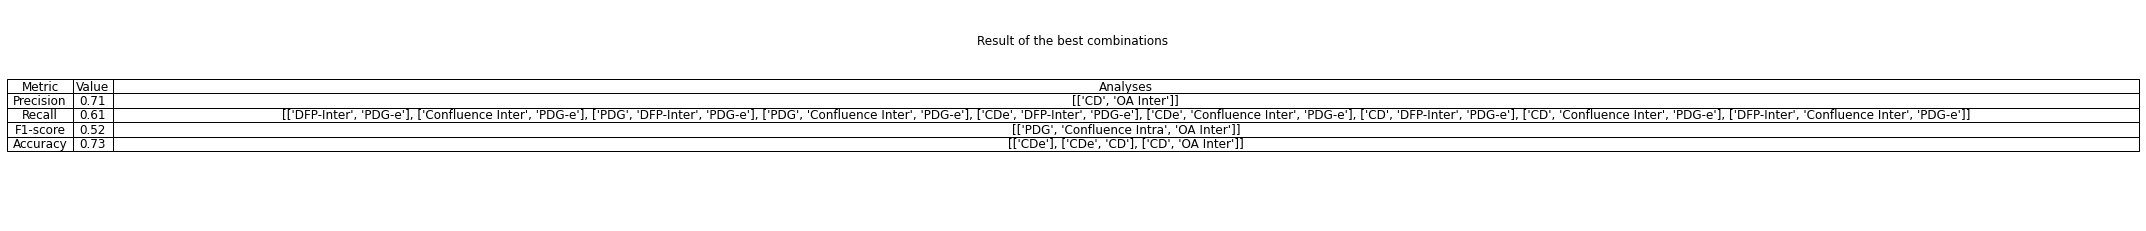

In [105]:
data = {
    'Metric': ['Precision', 'Recall', 'F1-score', 'Accuracy'],
    'Value': [round(best.maiorPrecision, 2), round(best.maiorRecall, 2), round(best.maiorF1, 2), round(best.maiorAcuracia, 2)],
   'Analyses': [get_reverse_name(best.mPrecision), get_reverse_name(best.mRecall), get_reverse_name(best.mF1), get_reverse_name(best.mAcuracia)]
}
dframe = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=dframe.values, colLabels=dframe.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

for i, col in enumerate(dframe.columns):
    col_width = max([len(str(val)) for val in dframe[col]])
    table.auto_set_column_width(i)
    table.auto_set_column_width(col_width)

plt.title("Result of the best combinations", y=0.8)

plt.savefig('best_combinations.jpg', dpi=300, bbox_inches='tight', pad_inches=0.5)



In [109]:

def check_exclusive(op1, op2, val):
    
    count = 0
    for i, j in zip(op1, op2):
        if (val in i and (val not in j)):
            count = count + 1
    return count

In [110]:
def check_algorithm_tp_fp(first, last):
    first_tp = check_exclusive(first, last, "TRUE POSITIVE")
    first_fp = check_exclusive(first, last, "FALSE POSITIVE")
    r_first = first_tp-first_fp
    print("TP exclusive first:", first_tp, ", FP exclusive first:", first_fp, ", saldo:", r_first)
    
    last_tp = check_exclusive(last, first, "TRUE POSITIVE")
    last_fp = check_exclusive(last, first, "FALSE POSITIVE")
    r_last = last_tp-last_fp
    print("TP exclusive last:", last_tp, ", FP exclusive last:", last_fp, ", saldo:", r_last)

    if (r_first > r_last):
        print("Escolher first (OR)!")
    elif (r_first < r_last):
        print("Escolher last!")
    else:
        print("Ficar com a mais rápida!")

In [111]:
#Escolhendo qual o melhor resultado com base na tabela de TP - FP
obj = Longest()
for first_elements in analysis_combination: 
    for last_element in analysis_combination:
        if first_elements != last_element:
            # print(i, first_elements, last_element)
            r_first = calculate_matrix(first_elements)
            r_last = calculate_matrix(last_element)

            print("Comparing OR of the first", first_elements, "with the last", last_element)
            print("First:", count_fp_fn(r_first))
            
            obj.confusion_matrix(count_fp_fn(r_first), first_elements)
            print("Last: ", count_fp_fn(r_last))
            obj.confusion_matrix(count_fp_fn(r_last), last_element)

            check_algorithm_tp_fp(r_first, r_last)
            print()

Comparing OR of the first ['left right PDG', 'right left PDG'] with the last ['left right CDe', 'right left CDe']
First: ['FALSE POSITIVE: 15', 'TRUE POSITIVE: 14', 'TRUE NEGATIVE: 51', 'FALSE NEGATIVE: 19']
Precision: 0.48
Recall: 0.42
F1 Score: 0.45
Accuracy: 0.66
Last:  ['FALSE POSITIVE: 8', 'FALSE NEGATIVE: 19', 'TRUE POSITIVE: 14', 'TRUE NEGATIVE: 58']
Precision: 0.64
Recall: 0.42
F1 Score: 0.51
Accuracy: 0.73
TP exclusive first: 4 , FP exclusive first: 13 , saldo: -9
TP exclusive last: 4 , FP exclusive last: 6 , saldo: -2
Escolher last!

Comparing OR of the first ['left right PDG', 'right left PDG'] with the last ['left right CD', 'right left CD']
First: ['FALSE POSITIVE: 15', 'TRUE POSITIVE: 14', 'TRUE NEGATIVE: 51', 'FALSE NEGATIVE: 19']
Precision: 0.48
Recall: 0.42
F1 Score: 0.45
Accuracy: 0.66
Last:  ['TRUE NEGATIVE: 66', 'FALSE NEGATIVE: 25', 'TRUE POSITIVE: 8']
Precision: 0.00
Recall: 0.24
F1 Score: 0.00
Accuracy: 0.00
TP exclusive first: 6 , FP exclusive first: 15 , saldo:

KeyboardInterrupt: 

In [17]:
# Calcular pontuação para cada resultado
def calculate_score(metrics, weights):
    return sum(metrics[metric] * weights[metric] for metric in metrics)

def check_algorithm_weights(first, last, precision, recall, f1_score, accuracy):
    obj = Longest()
    result_1_metrics = obj.confusion_matrix(count_fp_fn(first), first)
    result_2_metrics = obj.confusion_matrix(count_fp_fn(last), last)
    
    # Definir pesos para as métricas (você pode ajustar esses pesos)
    weights = {
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
        "accuracy": accuracy
    }

    score_1 = calculate_score(result_1_metrics, weights)
    score_2 = calculate_score(result_2_metrics, weights)

    print(f"Score First: {score_1:.2f}")
    print(f"Score Last: {score_2:.2f}")

    # Determinar qual resultado é melhor com base na pontuação
    if score_1 > score_2:
        best_result = "First"
    else:
        best_result = "Last"

    print(f"O melhor resultado é {best_result}!")


In [18]:
#Escolhendo qual o melhor resultado com base na tabela de TP - FP

for first_elements in analysis_combination:
    for last_element in analysis_combination:
        if first_elements != last_element:
                    
            r_first = calculate_matrix(first_elements)
            r_last = calculate_matrix(last_element)

            print("Comparing OR of the first", first_elements, "with the last", last_element)
            print("First:", count_fp_fn(r_first))
            print("Last: ", count_fp_fn(r_last))

            # "precision": 0.4
            # "recall": 0.3
            # "f1_score": 0.2
            # "accuracy": 0.1
            check_algorithm_weights(r_first, r_last, 0.4, 0.3, 0.2, 0.1)


            print()

Comparing OR of the first ['Confluence Inter'] with the last ['OA Inter']
First: ['TRUE NEGATIVE: 48', 'FALSE NEGATIVE: 27', 'TRUE POSITIVE: 6', 'FALSE POSITIVE: 18']
Last:  ['TRUE NEGATIVE: 62', 'FALSE NEGATIVE: 29', 'TRUE POSITIVE: 4', 'FALSE POSITIVE: 4']
Precision: 0.25
Recall: 0.18
F1 Score: 0.21
Accuracy: 0.55
Precision: 0.50
Recall: 0.12
F1 Score: 0.20
Accuracy: 0.67
Score First: 0.25
Score Last: 0.34
O melhor resultado é Last!

Comparing OR of the first ['Confluence Inter'] with the last ['left right DFP-Inter', 'right left DFP-Inter']
First: ['TRUE NEGATIVE: 48', 'FALSE NEGATIVE: 27', 'TRUE POSITIVE: 6', 'FALSE POSITIVE: 18']
Last:  ['TRUE NEGATIVE: 45', 'FALSE NEGATIVE: 22', 'TRUE POSITIVE: 11', 'FALSE POSITIVE: 21']
Precision: 0.25
Recall: 0.18
F1 Score: 0.21
Accuracy: 0.55
Precision: 0.34
Recall: 0.33
F1 Score: 0.34
Accuracy: 0.57
Score First: 0.25
Score Last: 0.36
O melhor resultado é Last!

Comparing OR of the first ['Confluence Inter'] with the last ['left right PDG', 'r

In [277]:
#testando algoritmo de OU exclusivo genérico

# data_dict = {'PDG': ['FALSE POSITIVE', 'TRUE POSITIVE'],
# 'CDe': ['FALSE POSITIVE', 'TRUE POSITIVE'],
# 'CD': ['FALSE POSITIVE', 'TRUE POSITIVE'],
# 'DFP-Inter': ['FALSE POSITIVE', 'TRUE POSITIVE'],
# 'Confluence Inter': ['FALSE POSITIVE', 'FALSE POSITIVE'],
# 'DFP-Intra': ['TRUE POSITIVE', 'TRUE POSITIVE'],
# 'PDG-e': ['FALSE POSITIVE', 'TRUE POSITIVE'],
# 'Confluence Intra': ['FALSE POSITIVE', 'TRUE POSITIVE'],
# 'OA Inter': ['FALSE POSITIVE', 'TRUE POSITIVE']}

def check_equals_all(val, dict, pos):
    result = False
    for lista in dict.values():
        if (lista[pos] in val):
            result = True 
    return result        


def calculate_exclusive(data_dict, val):
    n = len(data_dict[next(iter(data_dict))])
    final_dict = {}
    for actual_key, actual_item in data_dict.items():
        final_dict[actual_key] = 0    
        data_dict_exclude = {chave: valor for chave, valor in data_dict.items() if chave != actual_key}
        cont = 0
        for i in range(n):
            all_equals_val = check_equals_all(val, data_dict_exclude, i)
            if val in actual_item[i] and not all_equals_val:
                cont = cont + 1
                print(actual_key)
        final_dict[actual_key] = cont
    return final_dict
        

In [294]:
analysis_exclusive = []
lista_de_listas = [[item] for item in analysis_name]

for i in lista_de_listas:
    analysis_exclusive.append(get_name_analysis(i))
print(analysis_exclusive)


[['left right PDG', 'right left PDG'], ['left right CDe', 'right left CDe'], ['left right CD', 'right left CD'], ['left right DFP-Inter', 'right left DFP-Inter'], ['Confluence Inter'], ['left right DFP-Intra', 'right left DFP-Intra'], ['left right PDG-e', 'right left PDG-e'], ['Confluence Intra'], ['OA Inter']]


In [311]:
def get_name(list_name):
    for i in list_name:
        if "left right " in i:
            return (i.replace("left right ", ""))    
        elif "right left " not in i:
            return i
    return ""

Exclusive TP
PDG-e

Exclusive FP
DFP-Inter
DFP-Inter
Confluence Inter
Confluence Inter
PDG-e


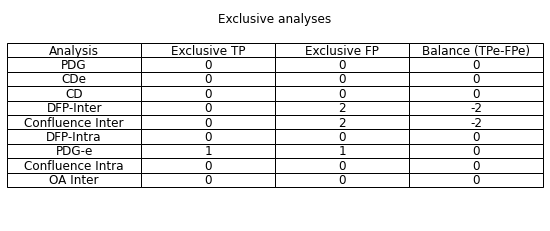

In [312]:
#Cálculo de TP e FP exclusivo para cada análise
data_dict = {}

for i in analysis_exclusive:
    data_dict[get_name(i)] = calculate_matrix(i) 

print("Exclusive TP")
res_tp = calculate_exclusive(data_dict, "TRUE POSITIVE")
# print(res_tp)


print("\nExclusive FP")
res_fp = calculate_exclusive(data_dict, "FALSE POSITIVE")
# print(res_fp)

data = {
    'Analysis': res_tp.keys(),
    'Exclusive TP': res_tp.values(),
    'Exclusive FP': res_fp.values()
}

dframe = pd.DataFrame(data)
dframe['Balance (TPe-FPe)'] = dframe['Exclusive TP'] - dframe['Exclusive FP']

fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=dframe.values, colLabels=dframe.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

plt.title("Exclusive analyses", y=0.9)
plt.savefig('exclusive_analysis.jpg', dpi=300, bbox_inches='tight', pad_inches=0.5)



In [20]:
# 

df_t = pd.read_csv('resultTime-1.csv', sep=';', encoding='utf-8', on_bad_lines='skip', low_memory=False)

# analysis = ["OR Result", "Confluence Inter Result", "OA Inter Result", "DF Inter Result", "PDG Result"]
# result_analysis = ["Confluence Inter", "OA Inter", "left right DFP-Inter", "right left DFP-Inter", "left right PDG", "right left PDG"]


In [21]:
def get_name_analysis_time(list_name, config):
    names = []
    for i in list_name:
        if ("Confluence" in str(i) and "Config CF left-base" not in names and "Confluence left-base" not in names):
            if config:
                names.append("Config CF left-base")
                names.append("Config CF right-base")
            names.append("Confluence left-base")
            names.append("Confluence right-base")
        elif ("OA Inter" in str(i)):
            if config:
                names.append("Config OA Inter")
            names.append("OA Inter")
        elif ("DF" in str(i) and "Config DFP left" not in names and "DFP left" not in names):
            if config:
                names.append("Config DFP left")
                names.append("Config DFP right")
            names.append("DFP left")
            names.append("DFP right")
        elif ("PDG" in str(i) and "Config PDG left" not in names and "PDG left" not in names):
            if config:
                names.append("Config PDG left")
                names.append("Config PDG right")
            names.append("PDG left")
            names.append("PDG right")

    return names

In [22]:
def sum_n_esimo_element(lista_de_listas, n):
    return sum(sublista[n] for sublista in lista_de_listas)

def get_sum_all_list(all_list):
    return [sum_n_esimo_element(all_list, i) for i in range(len(all_list[0]))]

def get_total_time(list_analysis):
    result = []
    for column_analysis in list_analysis:
        actual_time = [i for i in df_t[column_analysis]]
        result.append(actual_time)
    return result

def get_mean(values):
    return pd.Series(get_sum_all_list(values)).mean()

def get_median(values):
    return pd.Series(get_sum_all_list(values)).median()

def get_sum(values):
    return pd.Series(get_sum_all_list(values)).sum()

def get_standard_desviation(values):
    return pd.Series(get_sum_all_list(values)).std()

In [23]:
def get_mean_metric(metric, config):
    metric_t = []
    for i in metric:
        aux_list = get_name_analysis_time(i, config)
        result = get_total_time(aux_list)
        value = round(pd.Series(get_mean(result)).sum(), 2)
        metric_t.append(value)
    return metric_t

def get_sum_metric(metric, config):
    metric_t = []
    for i in metric:
        aux_list = get_name_analysis_time(i, config)
        result = get_total_time(aux_list)
        value = round(pd.Series(get_sum(result)).sum(), 2)
        metric_t.append(value)
    return metric_t

def get_median_metric(metric, config):
    metric_t = []
    for i in metric:
        aux_list = get_name_analysis_time(i, config)
        result = get_total_time(aux_list)
        value = round(pd.Series(get_median(result)).sum(), 2)
        metric_t.append(value)
    return metric_t

def get_std_metric(metric, config):
    metric_t = []
    for i in metric:
        aux_list = get_name_analysis_time(i, config)
        result = get_total_time(aux_list)
        value = round(pd.Series(get_standard_desviation(result)).sum(), 2)
        metric_t.append(value)
    return metric_t


In [24]:

with_config = True

colums = df_t.columns

print("Analyzing", best.mPrecision)
mean_p = get_mean_metric(best.mPrecision, with_config)
median_p = get_median_metric(best.mPrecision, with_config)
# sum_p = get_sum_metric(best.mPrecision, with_config)
std_p = get_std_metric(best.mPrecision, with_config)

# out_precision = f"Mean: {mean_p} Median: {median_p} Sum: {sum_p} Standard: {std_p}"
out_precision = [mean_p, median_p, std_p]

print(out_precision)

print("Analyzing", best.mRecall)
mean_p = get_mean_metric(best.mRecall, with_config)
median_p = get_median_metric(best.mRecall, with_config)
# sum_p = get_sum_metric(best.mRecall, with_config)
std_p = get_std_metric(best.mRecall, with_config)

# out_recall = f"Mean: {mean_p} Median: {median_p} Sum: {sum_p} Standard: {std_p}"
out_recall = [mean_p, median_p, std_p]

print(out_recall)

print("Analyzing", best.mF1)

mean_p = get_mean_metric(best.mF1, with_config)
median_p = get_median_metric(best.mF1, with_config)
# sum_p = get_sum_metric(best.mF1, with_config)
std_p = get_std_metric(best.mF1, with_config)

# out_f1 = f"Mean: {mean_p} Median: {median_p} Sum: {sum_p} Standard: {std_p}"
out_f1 = [mean_p, median_p, std_p]
print(out_f1)

print("Analyzing", best.mAcuracia)
mean_p = get_mean_metric(best.mAcuracia, with_config)
median_p = get_median_metric(best.mAcuracia, with_config)
# sum_p = get_sum_metric(best.mAcuracia, with_config)
std_p = get_std_metric(best.mAcuracia, with_config)

# out_accuracy = f"Mean: {mean_p}\nMedian: {median_p}\nSum: {sum_p}\nStandard: {std_p}\n"
out_accuracy = [mean_p, median_p, std_p]
print(out_accuracy)



Analyzing [['OA Inter'], ['OA Inter', 'left right PDG', 'right left PDG']]


KeyError: 'Config OA Inter'

In [ ]:
def convert_list_to_tuple(out):
    result = []
    for index in range(len(out[0])):
        val = [x[index] for x in out]
        result.append(tuple(val))
    return result

In [ ]:
data = {
    'Metric': ['Precision', 'Recall', 'F1-score', 'Accuracy'],
    'Value': [round(obj.maiorPrecision, 2), round(obj.maiorRecall, 2), round(obj.maiorF1, 2), round(obj.maiorAcuracia, 2)],
    'Analyses': [get_reverse_name(obj.mPrecision), get_reverse_name(obj.mRecall), get_reverse_name(obj.mF1), get_reverse_name(obj.mAcuracia)],
    'Time (s) (mean, median, standard)': [convert_list_to_tuple(out_precision), convert_list_to_tuple(out_recall), convert_list_to_tuple(out_f1), convert_list_to_tuple(out_accuracy)]
}
dframe = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=dframe.values, colLabels=dframe.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

for i, col in enumerate(dframe.columns):
    col_width = max([len(str(val)) for val in dframe[col]])
    table.auto_set_column_width(i)
    table.auto_set_column_width(col_width)

plt.title("Result of the best combinations", y=0.8)

plt.savefig('best_combinations_time.jpg', dpi=300, bbox_inches='tight', pad_inches=0.5)



In [ ]:
print(len(analysis_combination))
print(analysis_combination)